## Case-Study: Maintenance Communities within the RNV network


The RNV (Rhein-Neckar-Verkehr GmbH) wants to improve its ability to respond to break-downs in their transportation network by reorganizing their service and maintenance organization. The current plan is to replace the single maintenance team for the entire network with three maintenance teams, each responsible for a small set of stops in the RNV network.

Your objective is to propose three sets of stops to the RNV that will enable them to create the three maintenance teams they plan to implement. Each set of stops should be assigned to a different maintenance team to ensure that the RNV network can be properly maintained and serviced.

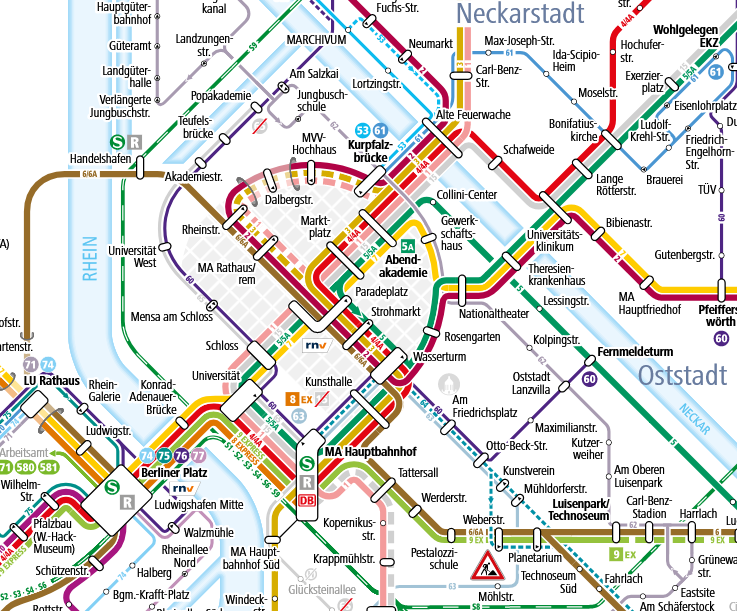

The RNV network contains tram stops and their connections in the network. Each stop is represented by a node, and the connections between them are represented by edges.
The network was created based on the data from the [RNV open data portal](https://www.opendata-oepnv.de//ht/de/organisation/verkehrsunternehmen/rnv/openrnv/datensaetze?tx_vrrkit_view%5Bdataset_name%5D=soll-fahrplandaten-rnv&tx_vrrkit_view%5Baction%5D=details&tx_vrrkit_view%5Bcontroller%5D=View).


Build a network graph using the tram stop dataset, where each stop is a node, and each connection between stops is an edge.
Visualize the graph.

In [1]:
import networkx as nx
# Load the graph and exclude the weights.
G_rnv = nx.read_edgelist("./rnv_connected_stations.txt", create_using=nx.Graph(), delimiter='\t', data=False)
print('Number of stops (nodes): ', len(G_rnv.nodes))
print('Number of connections (edges): ', len(G_rnv.edges))

Number of stops (nodes):  460
Number of connections (edges):  555


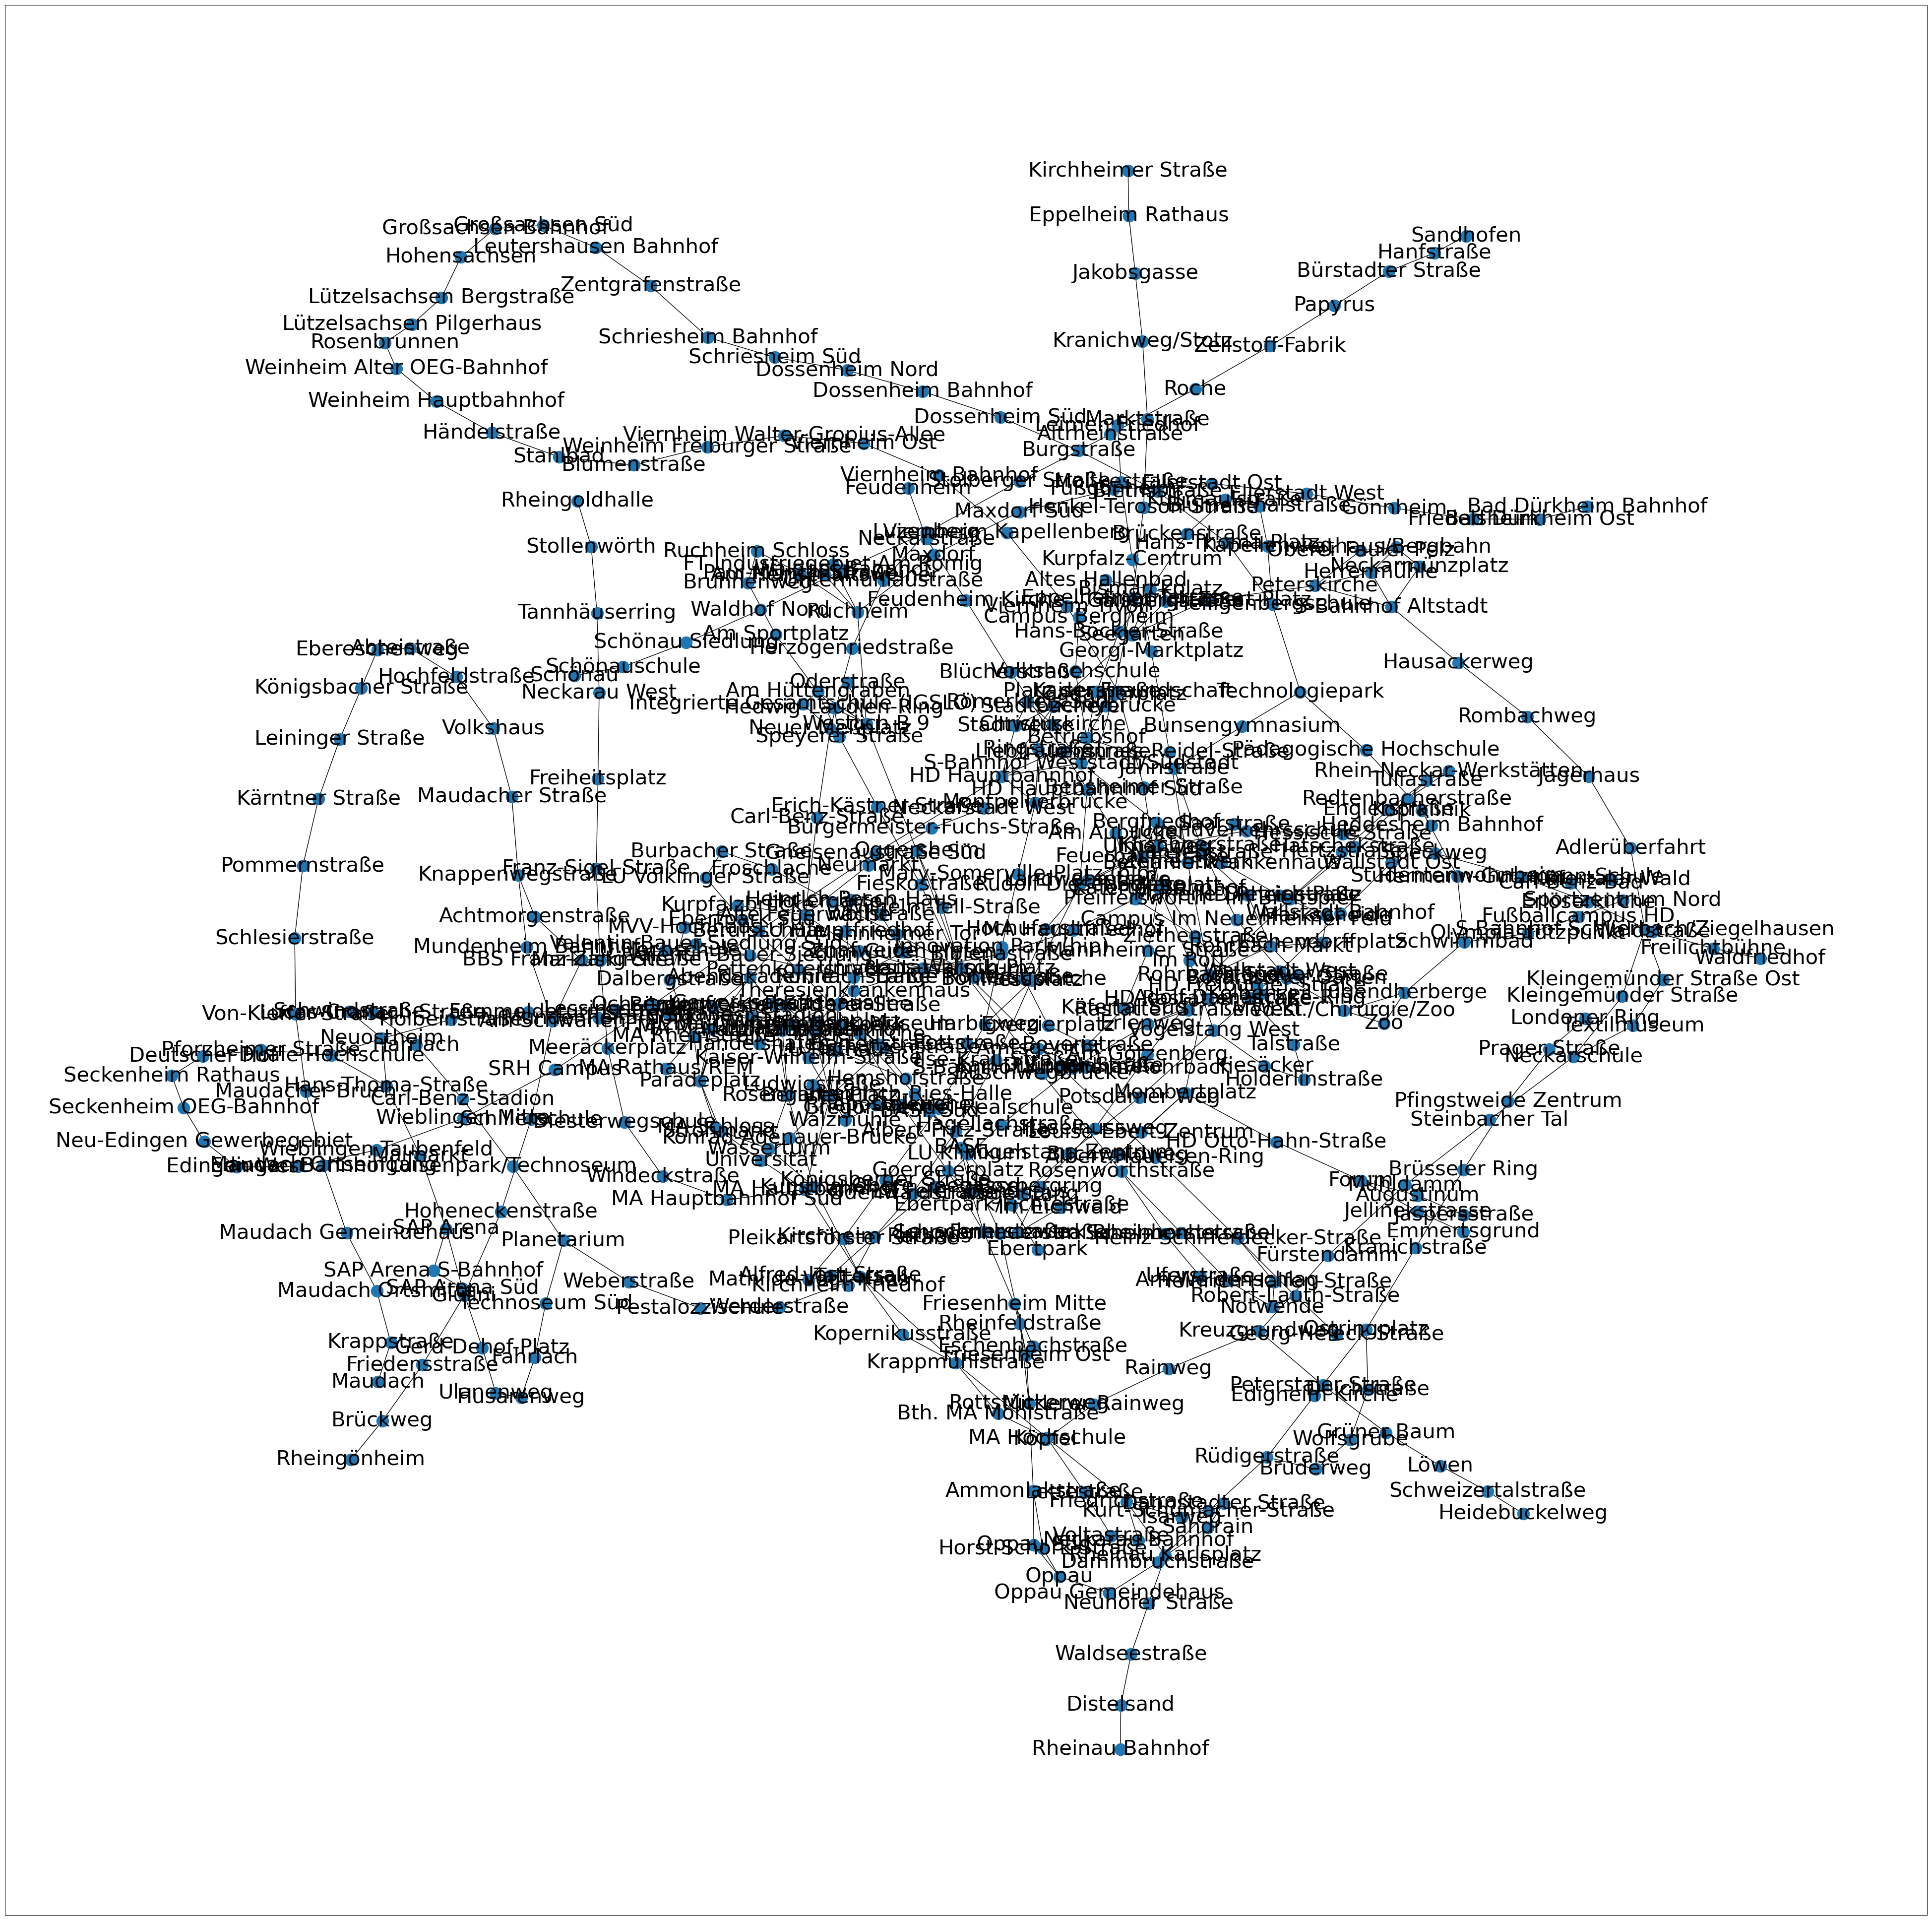

In [2]:
import matplotlib.pyplot as plt

nx.draw_networkx(G_rnv, font_size=30)
fig = plt.gcf()
fig.set_size_inches(50, 50)
plt.show()

## K-Cores

Run the k-cores algorithm to detect communities in the network.
Each stop should be at least connected to 3 other stops.

Visulize the resulting graph and interpret the result.
- Are k-cores a suitable approach for splitting the RNV network into groups of stations that are to be maintained by the different maintenance teams? 
- If not, which methods could deliver better results?

Component:
	 Hedwig-Laudien-Ring
	 Speyerer Straße
	 Am Hüttengraben
	 Westlich B 9

Component:
	 Bismarckplatz
	 Seegarten
	 Friedrich-Ebert-Platz
	 Gaisbergstraße



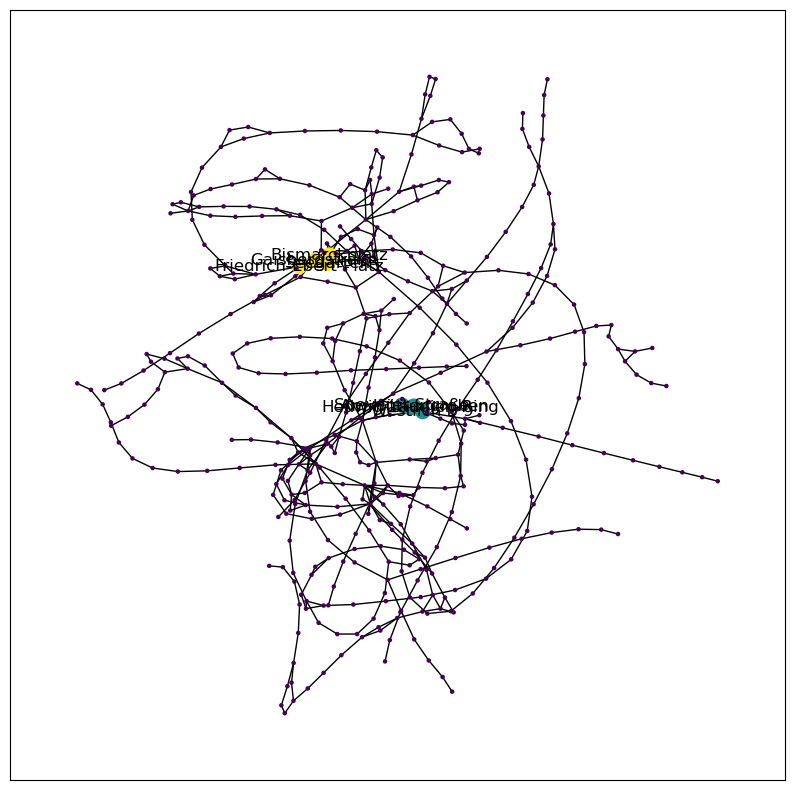

In [3]:
# Use Networkx k_core method with k=3
G_rnv_3_core = nx.k_core(G_rnv, 3)

# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in G_rnv.nodes()}
node_color_dict = {v:5 for v in G_rnv.nodes()}
node_size_dict = {v:5 for v in G_rnv.nodes()}

pos = nx.spring_layout(G_rnv, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(G_rnv_3_core):
    # Change color of nodes with this component
    current_color += 100
    print('Component:')
    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color
        
        print('\t {}'.format(node))
        # Add node label and size for the visualization
        node_label_dict[node] = node
        node_size_dict[node] = 100
    print('')
# Set node size and color of the output network
node_size = [node_size_dict[v] for v in G_rnv.nodes()]
node_color = [node_color_dict[v] for v in G_rnv.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(G_rnv, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict )
plt.show()

K-cores are a type of subgraph in a network where all nodes have at least k connections to other nodes within the subgraph. In the context of the RNV's transportation network, k-cores can be used to identify sets of stops that are highly interconnected. 

Unfortunately, the most stops of the RNV graph are not highly connected, because usually one stop is connected to at most two other stations. k-cores is not helpful in this context. Additionally, we neglect many stops in the network, because they are not added to any component.

## Divisive Hierarchical Clustering

Use divisive clustering to detect communities in the network.
The measure to find strong edges is edge betweenness.

Keep in mind that your goal is to identity 3 maintenance organizations (communitites).

In [4]:
# Divisive Clustering based on Edge Betweenness
G_rnv_clustered = G_rnv.copy()

while(True):
    # Identify "weakest" edge
    top_betweeness_edge_score = sorted(nx.edge_betweenness_centrality(G_rnv_clustered).items(), key=lambda item: item[1], reverse=True)[0]
    top_betweeness_edge = top_betweeness_edge_score[0]
    
    # Remove edge
    G_rnv_clustered.remove_edge(top_betweeness_edge[0], top_betweeness_edge[1])
    
    # Stop removing edges as soon as the graph is split into three components.
    if nx.number_connected_components(G_rnv_clustered) == 3:
        break

print('Number of components: {}'.format(nx.number_connected_components(G_rnv_clustered)))

Number of components: 3


Please visualize the maintenance groups in the graph. 

Each maintenance group needs a depot within their sub-component of the graph.
Determine for each maintenance group the five stops with the highest importance for the reliability of the network in the respective sub-component. A depot can be placed at one of these stops.

Which measure is suitable to determine the importance of a station for the reliability of the network?

Stops with the highest betweeness scores of the component: 
	 Rosengarten
	 Kunsthalle
	 Alte Feuerwache
	 Universitätsklinikum
	 Wasserturm
Stops with the highest betweeness scores of the component: 
	 Hans-Warsch-Platz
	 Valentin-Bauer-Siedlung
	 LU Hochschule
	 Rohrlachstraße
	 Westlich B 9
Stops with the highest betweeness scores of the component: 
	 S-Bahnhof Weststadt/Südstadt
	 Jahnstraße
	 HD Hauptbahnhof
	 Nansenstraße
	 Betriebshof


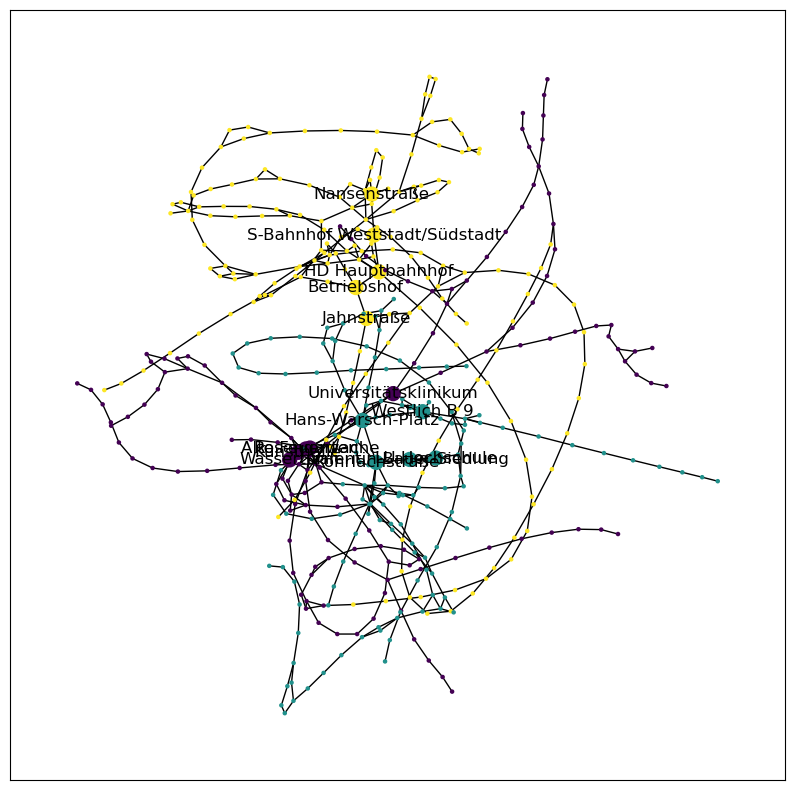

In [5]:
# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in G_rnv.nodes()}
node_color_dict = {v:5 for v in G_rnv.nodes()}
node_size_dict = {v:5 for v in G_rnv.nodes()}

pos = nx.spring_layout(G_rnv, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(G_rnv_clustered):
    # Change color of nodes with this component
    current_color += 100
    print('Stops with the highest betweeness scores of the component: ')
    # Determine subgraph of component and determine stops with the highest betweeness scores
    component_graph = G_rnv_clustered.copy()
    component_graph.remove_nodes_from([n for n in component_graph if n not in set(component)])
    top_betweeness_score_stops = [k for k,v in 
                                  sorted(nx.betweenness_centrality(component_graph, normalized =True).items(), 
                                         key=lambda item: item[1], reverse=True)[:5]]

    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color

        if node in top_betweeness_score_stops:
            print('\t {}'.format(node))
            # Add node label and size for the visualization
            node_label_dict[node] = node
            node_size_dict[node] = 100

# Set node size and color of the output network
node_size = [node_size_dict[v] for v in G_rnv.nodes()]
node_color = [node_color_dict[v] for v in G_rnv.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(G_rnv, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict )
plt.show()

We were looking for the betweenness score of the stops within the subcomponent.

The result of the divisive clustering technique is great, because it has successfully divided the network into three distinct components. What makes this finding even more fascinating is that each component represents one of the three cities Mannheim, Ludwigshafen, and Heidelberg. The division of the network into these communities is intuitively reasonable and could be highly valuable in helping the RNV reorganize their service and maintenance organization.